<a href="https://colab.research.google.com/github/ZackAkil/optimising-basketball/blob/master/shot%20prediction/where_did_i_shoot_from.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil ls gs://rugby-videos

gs://rugby-videos/VID_20181215_095232.mp4
gs://rugby-videos/deltas.joblib
gs://rugby-videos/deltas.mp4
gs://rugby-videos/output_320_full.mp4
gs://rugby-videos/y.joblib


In [2]:
!gsutil cp gs://rugby-videos/deltas.mp4 .

Copying gs://rugby-videos/deltas.mp4...
/ [1 files][  6.0 MiB/  6.0 MiB]                                                
Operation completed over 1 objects/6.0 MiB.                                      


In [3]:
!gsutil cp gs://rugby-videos/y.joblib .

Copying gs://rugby-videos/y.joblib...
/ [1 files][ 28.4 KiB/ 28.4 KiB]                                                
Operation completed over 1 objects/28.4 KiB.                                     


In [0]:
from sklearn.externals import joblib
from scipy.misc import imresize

In [0]:
ys = joblib.load('y.joblib')

In [0]:
!pip install scikit-video --quiet

In [0]:
from skvideo.io import vread
import numpy as np

In [0]:
X_delta = vread('deltas.mp4')[:,:,:,0]
X = np.expand_dims(X_delta, axis=3)
del(X_delta)

In [0]:
X.shape

(7000, 180, 320, 1)

In [0]:
# turn y coords in to a boolean flag for 'was a shot taken'
Valid_y = ~(np.array(ys['y']) == None)

In [0]:
y = np.zeros([len(Valid_y), 2])
y[:,0] = np.array(ys['x']) 
y[:,1] = np.array(ys['y'])
y = y[Valid_y]
y[:,0] /= 320.
y[:,1] /= 180.

In [0]:
X = X[Valid_y]

In [27]:
y.shape, X.shape

((1239, 2), (1239, 180, 320, 1))

In [0]:
import matplotlib.pyplot as plt

array([ 937,  378,  212,  253, 1220])

In [0]:
def show_random_frames(X, y):
  
  random_indexes = np.random.choice(range(len(y)), 5)

  # confirm that our y match with frames with shots
  for index in random_indexes:
    
    plt.imshow(X[index])
    plt.axvline(y[index, 0]*320)
    plt.axhline(y[index, 1]*180)
    plt.show()

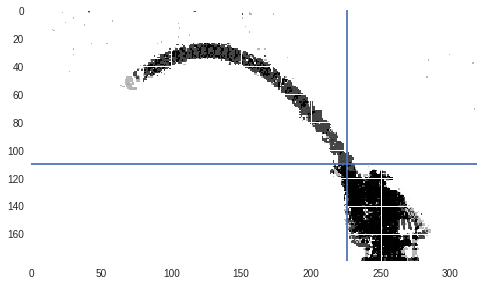

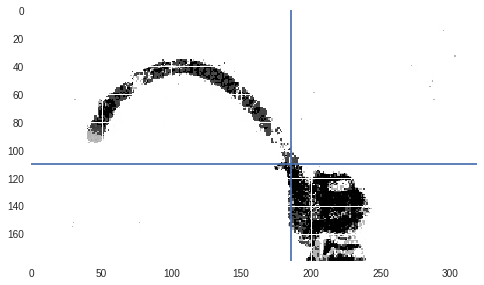

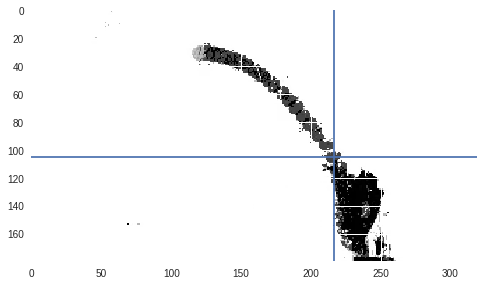

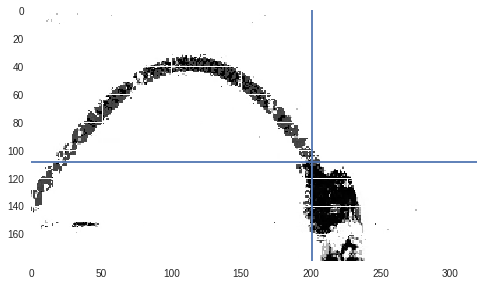

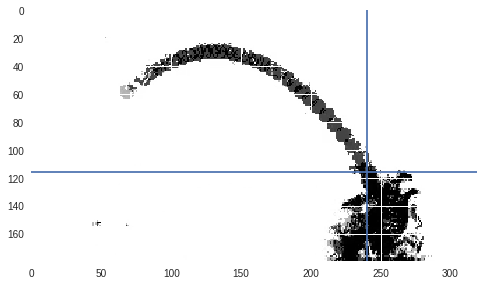

In [32]:
show_random_frames(X[:,:,:,0], y)

In [0]:
from sklearn.model_selection import train_test_split

In [34]:
y.shape

(1239, 2)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [0]:
del(X)

In [0]:
X_train = (X_train / 255.).astype(np.float32)
X_test = (X_test / 255.).astype(np.float32)

In [37]:
X_test.dtype

dtype('float32')

In [38]:
y.shape

(1239, 2)

In [39]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [40]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [41]:
X.shape

(1239, 180, 320, 1)

In [0]:
input_shape = (180, 320, 1)

In [0]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='linear'))

In [0]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['mean_squared_error'])

In [86]:
batch_size = 128
epochs = 20


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 830 samples, validate on 409 samples
Epoch 1/20
830/830 [==============================] - 2s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/20
830/830 [==============================] - 2s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/20
830/830 [==============================] - 2s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/20
830/830 [==============================] - 2s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 5/20
830/830 [==============================] - 2s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 6/20
830/830 [==============================] - 2s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0020 - val_mean_squa

In [0]:
def gray_to_channel(image):
  new_image = np.zeros([*image.shape[:2], 3])
  new_image[:,:,0] = image.reshape(image.shape[:2])
  new_image[:,:,1] = image.reshape(image.shape[:2])
  new_image[:,:,2] = image.reshape(image.shape[:2])
  return new_image

In [0]:
def show_frames(X, y, m=10):
  print(X.shape, y.shape)
  

  for i in range(m):
    
    plt.imshow(gray_to_channel(X[i]))
    plt.axvline(y[i, 0]*320)
    plt.axhline(y[i, 1]*180)
    plt.grid(False)
    plt.show()

(409, 180, 320, 1) (409, 2)


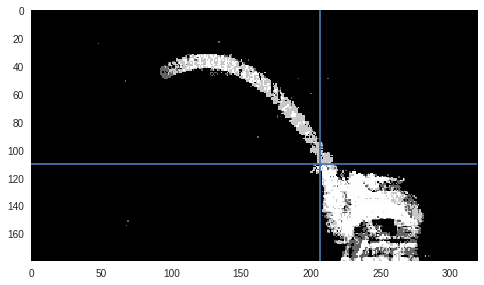

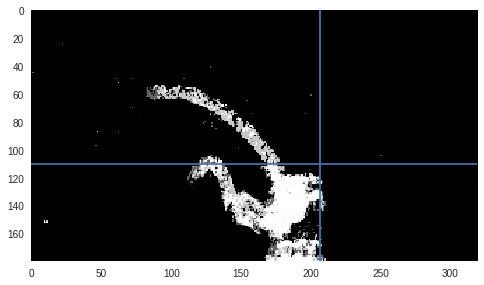

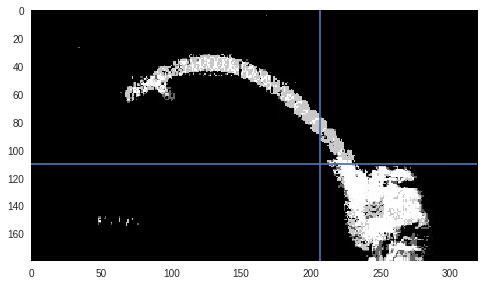

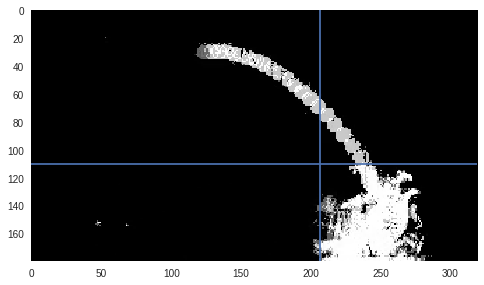

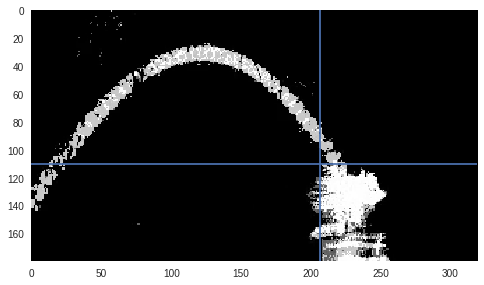

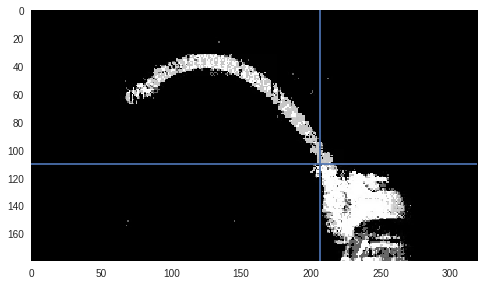

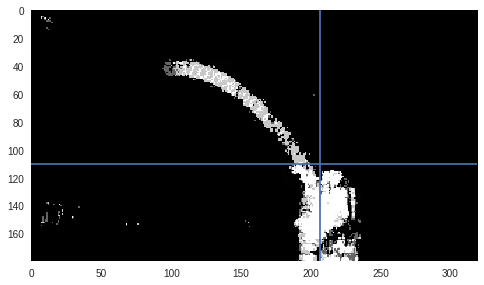

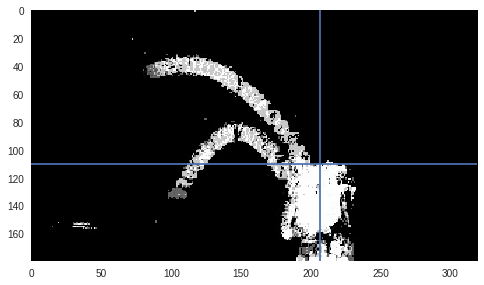

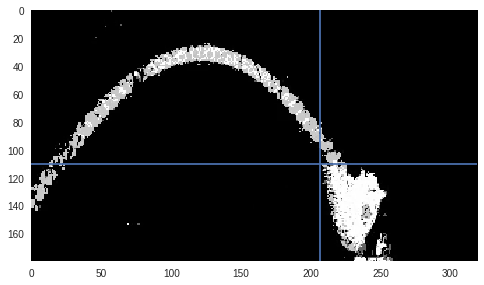

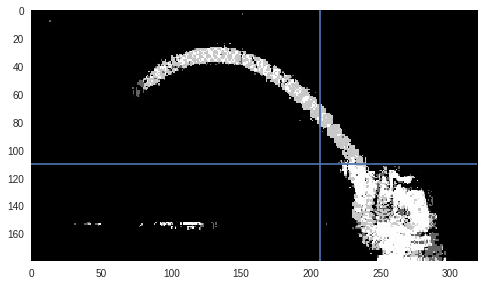

In [87]:
pred = model.predict(X_test)
show_frames(X_test, pred, m=10)

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [88]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Saved model to disk


In [89]:
! gsutil cp model.h5 gs://rugby-videos/model_where.h5

Copying file://model.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/27.2 MiB.                                     


In [90]:
! gsutil cp model.json gs://rugby-videos/model_where.json

Copying file://model.json [Content-Type=application/json]...
/ [1 files][  2.8 KiB/  2.8 KiB]                                                
Operation completed over 1 objects/2.8 KiB.                                      


In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 178, 318, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 176, 316, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 158, 8)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 88, 158, 8)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 111232)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                7118912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________